In [351]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.tsa.stattools import adfuller
 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

In [352]:
SplitTestDate = "2019-01-05"

In [353]:
df_train = pd.read_csv('data/processed_train.csv',index_col = 0)
df_final_test = pd.read_csv('data/processed_test.csv',index_col = 0)

In [354]:
df_final_test.date = df_final_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_train.date = df_train.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))


In [355]:
melt2 = df_train.copy()
melt2=melt2.dropna()
melt2=melt2.sort_values(['date', 'sku'])
del melt2['scaled_target']


In [356]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [357]:
#baseline : predictions are sales from previous week, we also perform cross-validation
mapes = []
for week in melt2[melt2['date']>=SplitTestDate].date.unique():
    train = melt2[melt2['date'] < week]
    val = melt2[melt2['date'] == week]

    p = val['sales w-1'].values

    error = mean_absolute_percentage_error(val['target'].values, p)
    print('Week {} - Error %.5f'.format(week) % ( error))
    mapes.append(error)
print('Mape = %.5f' % np.mean(mapes))

Week 2019-01-05T00:00:00.000000000 - Error 39.01220
Week 2019-01-12T00:00:00.000000000 - Error 17.70684
Week 2019-01-19T00:00:00.000000000 - Error 4.14878
Week 2019-01-26T00:00:00.000000000 - Error 9.97476
Week 2019-02-02T00:00:00.000000000 - Error 39.16745
Week 2019-02-09T00:00:00.000000000 - Error 27.68585
Week 2019-02-16T00:00:00.000000000 - Error 15.22213
Week 2019-02-23T00:00:00.000000000 - Error 10.98604
Week 2019-03-02T00:00:00.000000000 - Error 7.14624
Week 2019-03-09T00:00:00.000000000 - Error 42.92871
Week 2019-03-16T00:00:00.000000000 - Error 47.24889
Week 2019-03-23T00:00:00.000000000 - Error 2.51209
Week 2019-03-30T00:00:00.000000000 - Error 36.63410
Week 2019-04-06T00:00:00.000000000 - Error 26.92338
Week 2019-04-13T00:00:00.000000000 - Error 2.87755
Week 2019-04-20T00:00:00.000000000 - Error 33.09443
Week 2019-04-27T00:00:00.000000000 - Error 37.98056
Week 2019-05-04T00:00:00.000000000 - Error 12.15426
Week 2019-05-11T00:00:00.000000000 - Error 23.07060
Week 2019-05-18T0

In [358]:
#random forest with with sliding window validation. This allows to avoid having a very good model in a small amount of weeks simply due to luck
mean_error = []
k=0
for week in melt2[melt2['date']>=SplitTestDate].date.unique():
    train = melt2[melt2['date'] < week]
    val = melt2[melt2['date'] == week]
    del train['date']
    del val['date']
    xtr, xts = train.drop(['target'], axis=1), val.drop(['target'], axis=1)
    ytr, yts = train['target'].values, val['target'].values

    mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = mean_absolute_percentage_error(yts, p)
    print('Week %d - mape %.5f' % (week, error))
    mean_error.append(error)
print('Mape = %.5f' % np.mean(mean_error))

Week 1546646400000000000 - mape 18.98784
Week 1547251200000000000 - mape 14.26968
Week 1547856000000000000 - mape 6.35021
Week 1548460800000000000 - mape 4.74586
Week 1549065600000000000 - mape 11.11032
Week 1549670400000000000 - mape 11.52326
Week 1550275200000000000 - mape 5.63846
Week 1550880000000000000 - mape 8.90680
Week 1551484800000000000 - mape 6.42070
Week 1552089600000000000 - mape 8.20751
Week 1552694400000000000 - mape 12.02796
Week 1553299200000000000 - mape 3.90883
Week 1553904000000000000 - mape 5.09514
Week 1554508800000000000 - mape 6.98240
Week 1555113600000000000 - mape 3.41594
Week 1555718400000000000 - mape 5.92365
Week 1556323200000000000 - mape 11.40430
Week 1556928000000000000 - mape 11.09668
Week 1557532800000000000 - mape 13.90171
Week 1558137600000000000 - mape 17.61191
Week 1558742400000000000 - mape 8.66441
Week 1559347200000000000 - mape 10.78077
Week 1559952000000000000 - mape 13.71459
Week 1560556800000000000 - mape 4.20409
Week 1561161600000000000 - ma

In [360]:
#del xtr['date']
X=xtr.values

Feature ranking:
 1. feature  3 sales w-1 (0.415)
 2. feature  7 rolling1 (0.413)
 3. feature 27 scaled_price_diff1 (0.077)
 4. feature 15 scaled_price (0.024)
 5. feature  1   price (0.017)
 6. feature 11 rolling5 (0.009)
 7. feature 12   diff1 (0.008)
 8. feature 10 rolling4 (0.005)
 9. feature  2 volume_on_promo w-1 (0.004)
10. feature  8 rolling2 (0.003)
11. feature  9 rolling3 (0.003)
12. feature  0     sku (0.002)
13. feature  5 sales w-2 (0.002)
14. feature  6 sales w-3 (0.002)
15. feature 19 scaled_rolling2 (0.001)
16. feature 13   diff2 (0.001)
17. feature 26 percentage_diff1 (0.001)
18. feature 20 scaled_rolling3 (0.001)
19. feature 38 dayofyear (0.001)
20. feature 44 scaled_dayofyear (0.001)
21. feature 17 scaled_promo (0.001)
22. feature 16 scaled_sales1 (0.001)
23. feature 22 scaled_rolling5 (0.001)
24. feature 46 scaled_weekofyear (0.001)
25. feature 40 weekofyear (0.001)
26. feature 18 scaled_rolling1 (0.001)
27. feature 23 scaled_diff1 (0.001)
28. feature 14   diff3 (0.

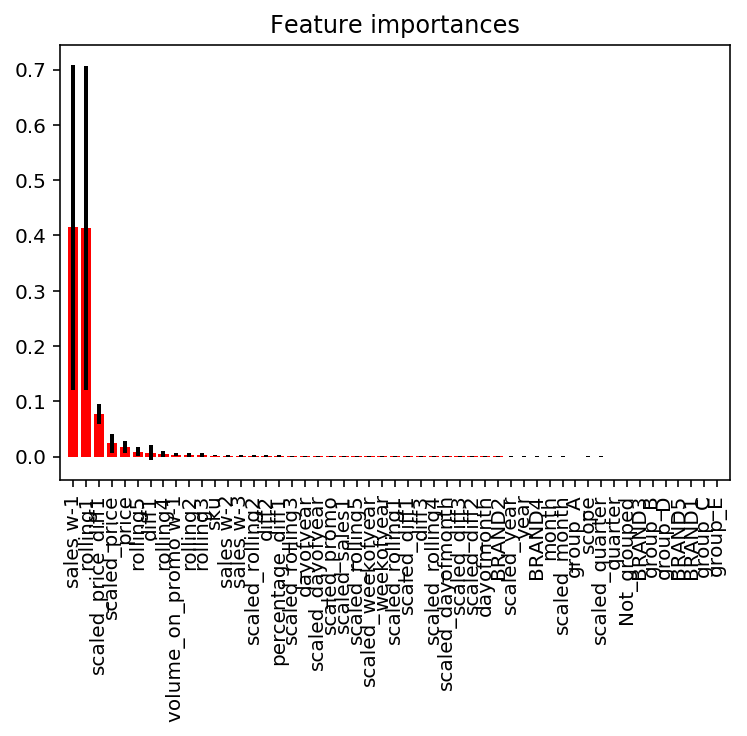

In [361]:
importances = mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in mdl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], xtr.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), xtr.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

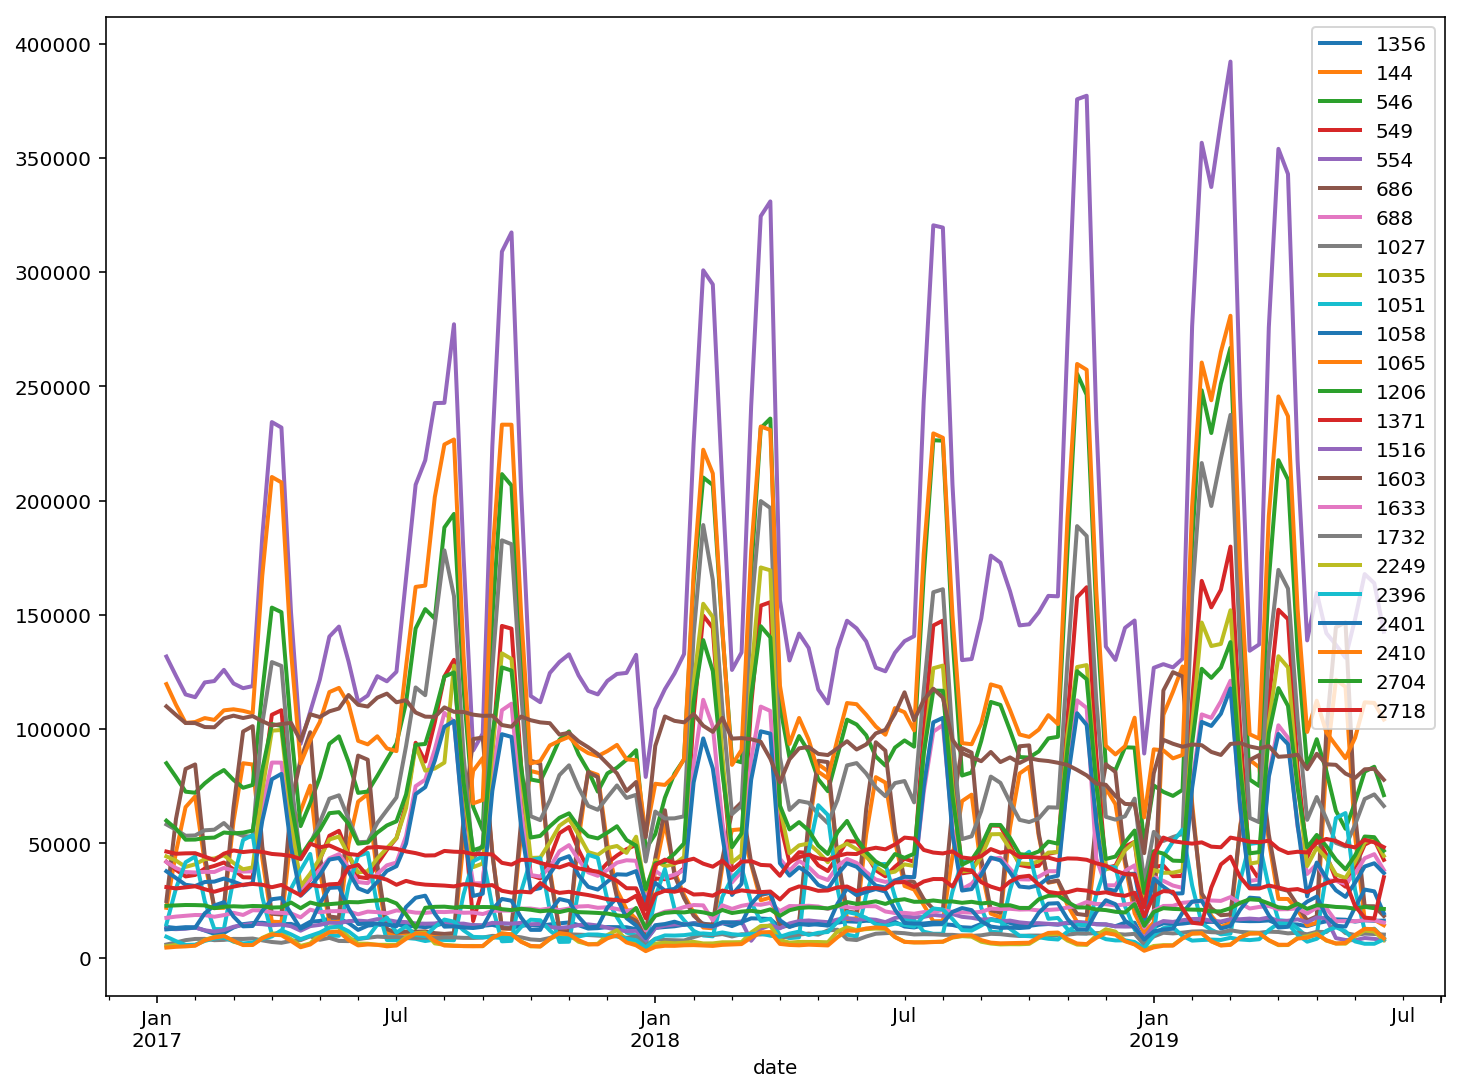

In [362]:
#Let's create a dataframe with all the products target to check if they are stazionary(using the Augmented Dicky-Fuller test)
melt5=melt2.copy()
melt5=melt5.dropna()
melt5.index=melt5.date
stocks = melt5[melt5.sku==1356].target.to_frame('1356')
skusss=[i for i in melt5.sku.unique() if i!=1356]
for i in skusss:
    stocks = stocks.join(melt5[melt5.sku==i].target.to_frame('{}'.format(i)))
stocks.plot(figsize=figsize);

In [363]:
def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
df_p=ADFuller(stocks)

In [364]:
#all the stationary products
df_p[df_p['p-value']<0.05]
staz_skus_list=[int(i) for i in df_p[df_p['p-value']<0.05].index]

In [365]:
melt2=melt2[np.isin(melt2["sku"],staz_skus_list)]

In [366]:
#random forest with with sliding window validation
mean_error = []
k=0
for week in melt2[melt2['date']>=SplitTestDate].date.unique():
    train = melt2[melt2['date'] < week]
    val = melt2[melt2['date'] == week]
    del train['date']
    del val['date']
    xtr, xts = train.drop(['target'], axis=1), val.drop(['target'], axis=1)
    ytr, yts = train['target'].values, val['target'].values

    mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = mean_absolute_percentage_error(yts, p)
    print('Week %d - mape %.5f' % (week, error))
    mean_error.append(error)
print('Mape = %.5f' % np.mean(mean_error))

Week 1546646400000000000 - mape 18.98784
Week 1547251200000000000 - mape 14.26968
Week 1547856000000000000 - mape 6.35021
Week 1548460800000000000 - mape 4.74586
Week 1549065600000000000 - mape 11.11032
Week 1549670400000000000 - mape 11.52326
Week 1550275200000000000 - mape 5.63846
Week 1550880000000000000 - mape 8.90680
Week 1551484800000000000 - mape 6.42070
Week 1552089600000000000 - mape 8.20751
Week 1552694400000000000 - mape 12.02796
Week 1553299200000000000 - mape 3.90883
Week 1553904000000000000 - mape 5.09514
Week 1554508800000000000 - mape 6.98240
Week 1555113600000000000 - mape 3.41594
Week 1555718400000000000 - mape 5.92365
Week 1556323200000000000 - mape 11.40430
Week 1556928000000000000 - mape 11.09668
Week 1557532800000000000 - mape 13.90171
Week 1558137600000000000 - mape 17.61191
Week 1558742400000000000 - mape 8.66441
Week 1559347200000000000 - mape 10.78077
Week 1559952000000000000 - mape 13.71459
Week 1560556800000000000 - mape 4.20409
Week 1561161600000000000 - ma

In [367]:
#Let's now try to use just the stazionary products which do not belong to the test set(scope equal to 1) and see if we can improve the MAPE
sku_scope_0=melt2[melt2.scope==0].sku.unique()
melt2=melt2[np.isin(melt2["sku"],[i for i in staz_skus_list if i in sku_scope_0])]

In [368]:
#random forest with with sliding window validation
mean_error = []
k=0
for week in melt2[melt2['date']>=SplitTestDate].date.unique():
    train = melt2[melt2['date'] < week]
    val = melt2[melt2['date'] == week]
    del train['date']
    del val['date']
    xtr, xts = train.drop(['target'], axis=1), val.drop(['target'], axis=1)
    ytr, yts = train['target'].values, val['target'].values

    mdl = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = mean_absolute_percentage_error(yts, p)
    print('Week %d - mape %.5f' % (week, error))
    mean_error.append(error)
print('Mape = %.5f' % np.mean(mean_error))

Week 1546646400000000000 - mape 17.30901
Week 1547251200000000000 - mape 9.72191
Week 1547856000000000000 - mape 2.29422
Week 1548460800000000000 - mape 6.71779
Week 1549065600000000000 - mape 7.42012
Week 1549670400000000000 - mape 5.34093
Week 1550275200000000000 - mape 5.12307
Week 1550880000000000000 - mape 6.22384
Week 1551484800000000000 - mape 7.45515
Week 1552089600000000000 - mape 5.92761
Week 1552694400000000000 - mape 4.19807
Week 1553299200000000000 - mape 2.18059
Week 1553904000000000000 - mape 3.74564
Week 1554508800000000000 - mape 4.24146
Week 1555113600000000000 - mape 2.70786
Week 1555718400000000000 - mape 3.53529
Week 1556323200000000000 - mape 9.74307
Week 1556928000000000000 - mape 6.34837
Week 1557532800000000000 - mape 3.22103
Week 1558137600000000000 - mape 12.49852
Week 1558742400000000000 - mape 7.69853
Week 1559347200000000000 - mape 11.28922
Week 1559952000000000000 - mape 11.19631
Week 1560556800000000000 - mape 6.59789
Week 1561161600000000000 - mape 6.26